# 📊 Clustering and Visualizing Text Data for Similarity

This project explores different text embeddings and clustering techniques to group similar text documents. The 20 Newsgroups dataset is used with 3 categories.

**1. Import Libraries**

In [2]:
# Basic
import numpy as np
import pandas as pd
import re

# Text Preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering
from sklearn.cluster import KMeans, DBSCAN

# Evaluation Metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Dimensionality Reduction for Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Embedding Models
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

# Dataset
from sklearn.datasets import fetch_20newsgroups

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aashi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aashi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Define categories
categories = ['comp.os.ms-windows.misc', 'rec.sport.hockey', 'soc.religion.christian']

# Load the dataset
newsgroups_data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

# Explore the data
print("Number of documents:", len(newsgroups_data.data))
print("Target names (categories):", newsgroups_data.target_names)
print("Sample document:\n")
print(newsgroups_data.data[0][:1000])  # print only first 1000 characters of the first sample

Number of documents: 2981
Target names (categories): ['comp.os.ms-windows.misc', 'rec.sport.hockey', 'soc.religion.christian']
Sample document:

I'd like to get a system running OS/2 2.0 GA talking to a network of PCs
running Windows for Workgroups.  Acting as a server would be wonderful,
but client access would be enough.

Can I run WFW 's NET utilities in a DOS box?  Or is there a way to actually
get OS/2 to talk to WFW?  Will OS/2 LanMan clients talk to WFW?

Dazed and confused,



**2. Text Preprocessing**

Basic cleaning, stopword removal, and lemmatization.

In [4]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize and remove stopwords + lemmatize
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(cleaned_tokens)

# Apply preprocessing
processed_texts = [preprocess_text(doc) for doc in newsgroups_data.data]

# Check output
print("Sample preprocessed text:\n")
print(processed_texts[0][:500])

Sample preprocessed text:

id like get system running o ga talking network pc running window workgroups acting server would wonderful client access would enough run wfw net utility do box way actually get o talk wfw o lanman client talk wfw dazed confused


**3. TF-IDF Embeddings**

Convert preprocessed text to sparse vectors using TF-IDF.

In [5]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features if needed

# Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(processed_texts)

# Output shape
print("TF-IDF Embedding shape:", X_tfidf.shape)

TF-IDF Embedding shape: (2981, 5000)


TF-IDF + KMeans

In [6]:
# Initialize KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model
kmeans.fit(X_tfidf)

# Get predicted cluster labels
kmeans_labels = kmeans.labels_

# Preview the labels
print("First 10 cluster labels:", kmeans_labels[:10])

First 10 cluster labels: [0 1 2 2 0 2 0 1 2 2]


In [7]:
# True labels
true_labels = newsgroups_data.target

# Evaluation metrics
ari = adjusted_rand_score(true_labels, kmeans_labels)
nmi = normalized_mutual_info_score(true_labels, kmeans_labels)
fmi = fowlkes_mallows_score(true_labels, kmeans_labels)

print(f"TF-IDF + KMeans - ARI: {ari:.4f}, NMI: {nmi:.4f}, FMI: {fmi:.4f}")

TF-IDF + KMeans - ARI: 0.4905, NMI: 0.5690, FMI: 0.6748


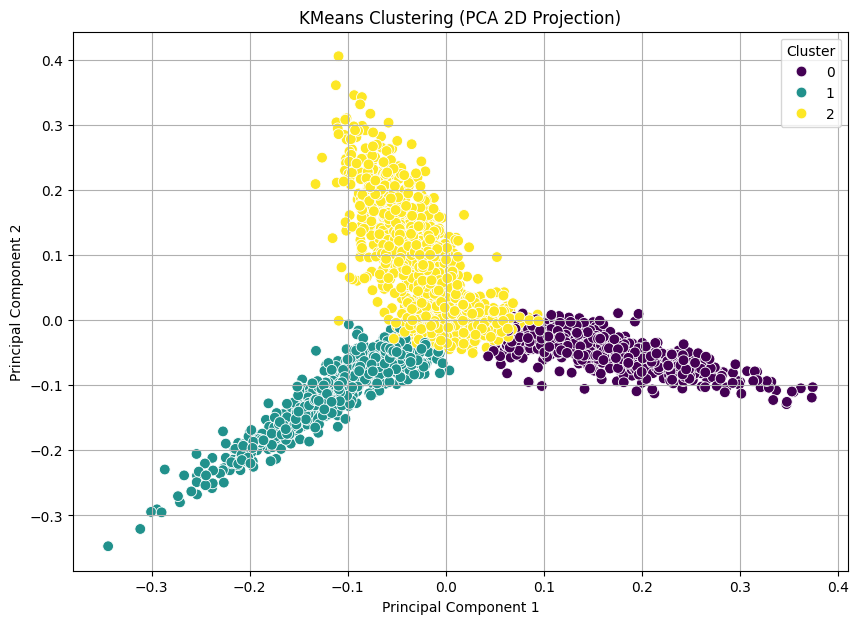

In [8]:
# Reduce to 2D using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='viridis', s=60)
plt.title("KMeans Clustering (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

TF-IDF + DBSCAN

In [9]:
from sklearn.preprocessing import StandardScaler

# Standardize TF-IDF features
X_scaled = StandardScaler(with_mean=False).fit_transform(X_tfidf)

# Initialize DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=5, metric='cosine')  # You can tune eps/min_samples

# Fit DBSCAN
dbscan_labels = dbscan.fit_predict(X_scaled)

# Filter out noise (-1 label)
valid_idx = dbscan_labels != -1
filtered_true = newsgroups_data.target[valid_idx]
filtered_preds = dbscan_labels[valid_idx]

# Evaluation
ari_db = adjusted_rand_score(filtered_true, filtered_preds)
nmi_db = normalized_mutual_info_score(filtered_true, filtered_preds)
fmi_db = fowlkes_mallows_score(filtered_true, filtered_preds)

# Results
print(f"TF-IDF + DBSCAN - ARI: {ari_db:.4f}, NMI: {nmi_db:.4f}, FMI: {fmi_db:.4f}")

TF-IDF + DBSCAN - ARI: 0.0000, NMI: 0.0000, FMI: 0.5772


C:\Users\aashi\AppData\Local\Temp\ipykernel_2500\3606756723.py:10: RuntimeWarning: invalid value encountered in scalar divide
  colors = ['gray' if label == -1 else plt.cm.viridis(label / max(unique_labels)) for label in dbscan_labels]


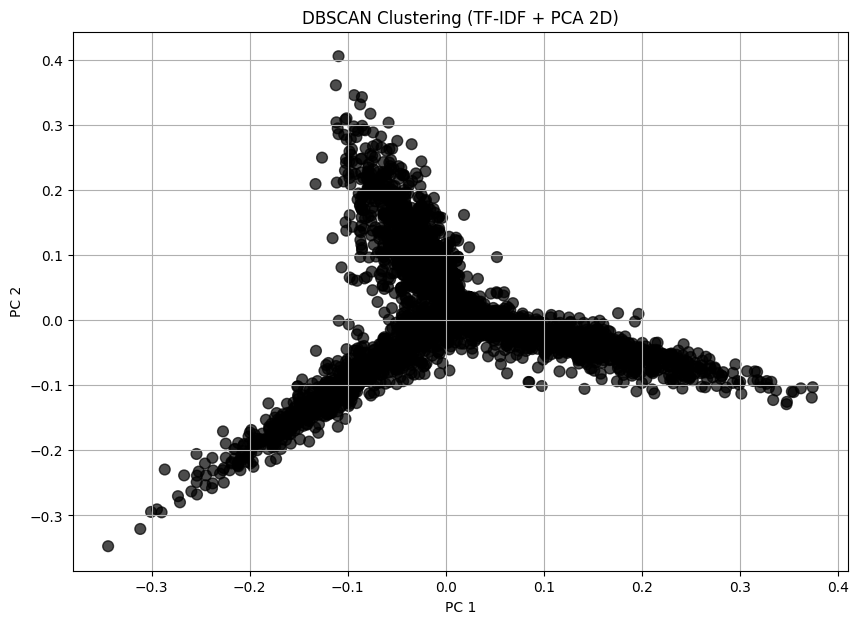

In [10]:
# Reduce to 2D using PCA for visualization
pca_dbscan = PCA(n_components=2, random_state=42)
X_pca_db = pca_dbscan.fit_transform(X_tfidf.toarray())

# Plot
plt.figure(figsize=(10, 7))
unique_labels = np.unique(dbscan_labels)

# Color map: gray for noise
colors = ['gray' if label == -1 else plt.cm.viridis(label / max(unique_labels)) for label in dbscan_labels]

plt.scatter(X_pca_db[:, 0], X_pca_db[:, 1], c=colors, s=60, alpha=0.7)
plt.title("DBSCAN Clustering (TF-IDF + PCA 2D)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()

**4. GloVe Embeddings**

In [11]:
# Load GloVe embeddings (100-dimensional)
glove_path = r"C:/Users/aashi/Downloads/glove.6B/glove.6B.100d.txt"
glove_embeddings = {}

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Function to create sentence-level embedding by averaging word vectors
def get_glove_embedding(text, embeddings_dict, dim=100):
    tokens = text.split()
    vectors = [embeddings_dict[word] for word in tokens if word in embeddings_dict]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

# Create sentence embeddings
X_glove = np.array([get_glove_embedding(text, glove_embeddings) for text in processed_texts])

# Check result
print("GloVe Embedding shape:", X_glove.shape)

GloVe Embedding shape: (2981, 100)


**GloVe + KMeans Clustering**

Visualized using PCA.

In [12]:
# KMeans on GloVe
kmeans_glove = KMeans(n_clusters=3, random_state=42)
kmeans_glove.fit(X_glove)
kmeans_glove_labels = kmeans_glove.labels_

# Evaluate
ari_km_glove = adjusted_rand_score(newsgroups_data.target, kmeans_glove_labels)
nmi_km_glove = normalized_mutual_info_score(newsgroups_data.target, kmeans_glove_labels)
fmi_km_glove = fowlkes_mallows_score(newsgroups_data.target, kmeans_glove_labels)

# Print results
print(f"GloVe + KMeans - ARI: {ari_km_glove:.4f}, NMI: {nmi_km_glove:.4f}, FMI: {fmi_km_glove:.4f}")

GloVe + KMeans - ARI: 0.7519, NMI: 0.6921, FMI: 0.8350


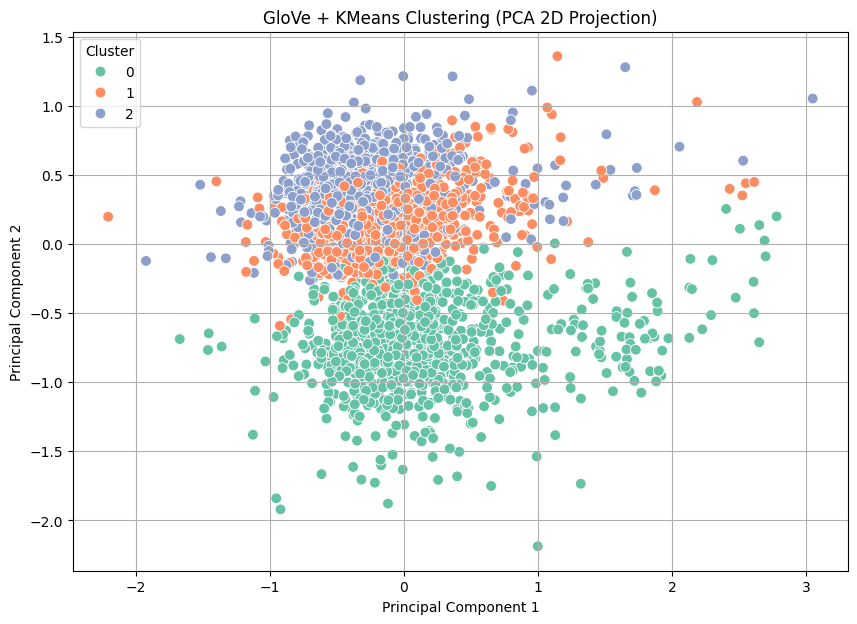

In [13]:
# PCA to 2D
pca_glove = PCA(n_components=2, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove)

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_glove_pca[:, 0], y=X_glove_pca[:, 1], hue=kmeans_glove_labels, palette='Set2', s=60)
plt.title("GloVe + KMeans Clustering (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

GloVe + DBSCAN

In [14]:
# Scale GloVe embeddings
X_glove_scaled = StandardScaler().fit_transform(X_glove)

# DBSCAN on GloVe
dbscan_glove = DBSCAN(eps=0.7, min_samples=5)
dbscan_glove_labels = dbscan_glove.fit_predict(X_glove_scaled)

# Filter out noise
valid_idx_glove = dbscan_glove_labels != -1
filtered_true_glove = newsgroups_data.target[valid_idx_glove]
filtered_preds_glove = dbscan_glove_labels[valid_idx_glove]

# Evaluate
ari_db_glove = adjusted_rand_score(filtered_true_glove, filtered_preds_glove)
nmi_db_glove = normalized_mutual_info_score(filtered_true_glove, filtered_preds_glove)
fmi_db_glove = fowlkes_mallows_score(filtered_true_glove, filtered_preds_glove)

# Results
print(f"GloVe + DBSCAN - ARI: {ari_db_glove:.4f}, NMI: {nmi_db_glove:.4f}, FMI: {fmi_db_glove:.4f}")

GloVe + DBSCAN - ARI: -0.0357, NMI: 0.0865, FMI: 0.5377


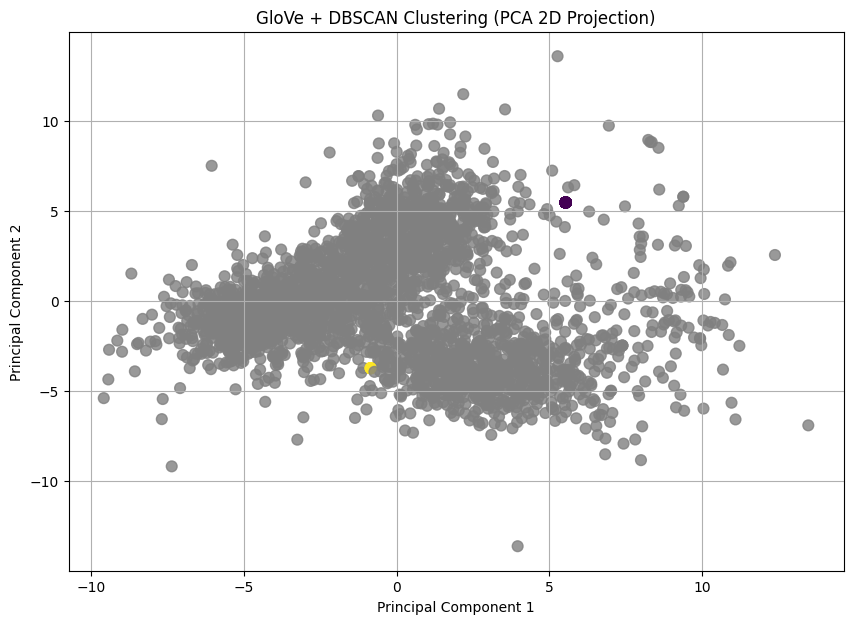

In [15]:
# PCA for GloVe
pca_glove = PCA(n_components=2, random_state=42)
X_glove_pca = pca_glove.fit_transform(X_glove_scaled)

# Plot DBSCAN clustering
plt.figure(figsize=(10, 7))
unique_labels = np.unique(dbscan_glove_labels)

# Assign colors (gray for noise)
colors = ['gray' if label == -1 else plt.cm.viridis(label / max(unique_labels)) for label in dbscan_glove_labels]

plt.scatter(X_glove_pca[:, 0], X_glove_pca[:, 1], c=colors, s=60, alpha=0.8)
plt.title("GloVe + DBSCAN Clustering (PCA 2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

**SentenceTransformer Embeddings**

In [16]:
# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the preprocessed texts
X_sbert = sbert_model.encode(processed_texts, show_progress_bar=True)

print("SBERT Embedding Shape:", X_sbert.shape)

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

SBERT Embedding Shape: (2981, 384)


KMeans on SBERT

In [17]:
categories = ['comp.os.ms-windows.misc', 'rec.sport.hockey', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

texts = newsgroups.data
targets = newsgroups.target

# Run KMeans
kmeans_sbert = KMeans(n_clusters=3, random_state=42)
sbert_kmeans_labels = kmeans_sbert.fit_predict(X_sbert)

# Evaluate
ari = adjusted_rand_score(targets, sbert_kmeans_labels)
nmi = normalized_mutual_info_score(targets, sbert_kmeans_labels)
fmi = fowlkes_mallows_score(targets, sbert_kmeans_labels)

print(f"SBERT + KMeans - ARI: {ari:.4f}, NMI: {nmi:.4f}, FMI: {fmi:.4f}")

SBERT + KMeans - ARI: 0.8358, NMI: 0.7934, FMI: 0.8907


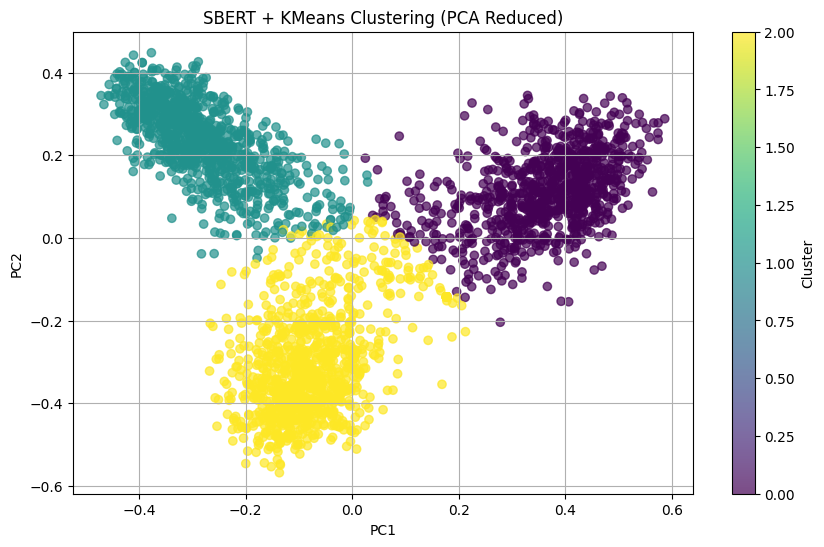

In [18]:
# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sbert)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=sbert_kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("SBERT + KMeans Clustering (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

**SBERT + KMeans: t-SNE Visualization**

c:\Users\aashi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


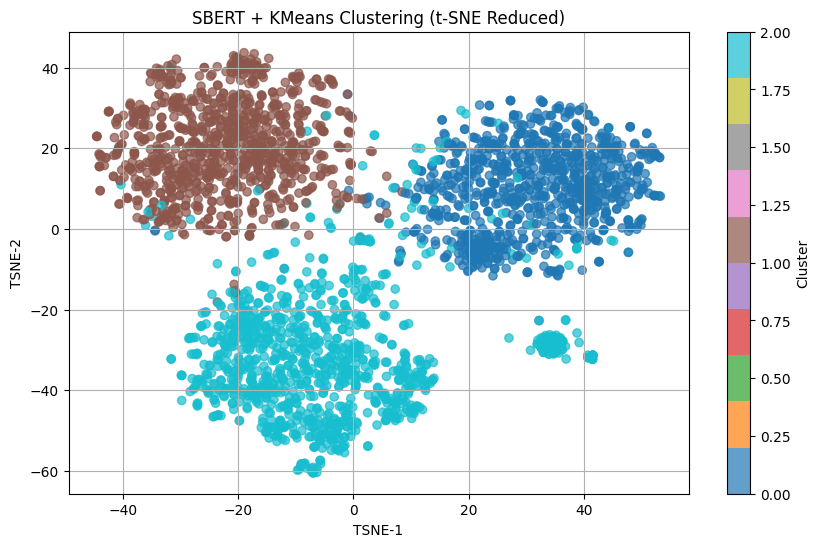

In [19]:
# Reduce SBERT embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=40, random_state=42, n_iter=1000)
X_sbert_tsne = tsne.fit_transform(X_sbert)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_sbert_tsne[:, 0], X_sbert_tsne[:, 1], c=sbert_kmeans_labels, cmap='tab10', alpha=0.7)
plt.title("SBERT + KMeans Clustering (t-SNE Reduced)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

DBSCAN on SBERT

In [20]:
# Run DBSCAN
dbscan_sbert = DBSCAN(eps=0.7, min_samples=5, metric='cosine')
sbert_dbscan_labels = dbscan_sbert.fit_predict(X_sbert)

# Evaluate
ari = adjusted_rand_score(targets, sbert_dbscan_labels)
nmi = normalized_mutual_info_score(targets, sbert_dbscan_labels)
fmi = fowlkes_mallows_score(targets, sbert_dbscan_labels)

print(f"SBERT + DBSCAN - ARI: {ari:.4f}, NMI: {nmi:.4f}, FMI: {fmi:.4f}")

SBERT + DBSCAN - ARI: 0.0000, NMI: 0.0008, FMI: 0.5766


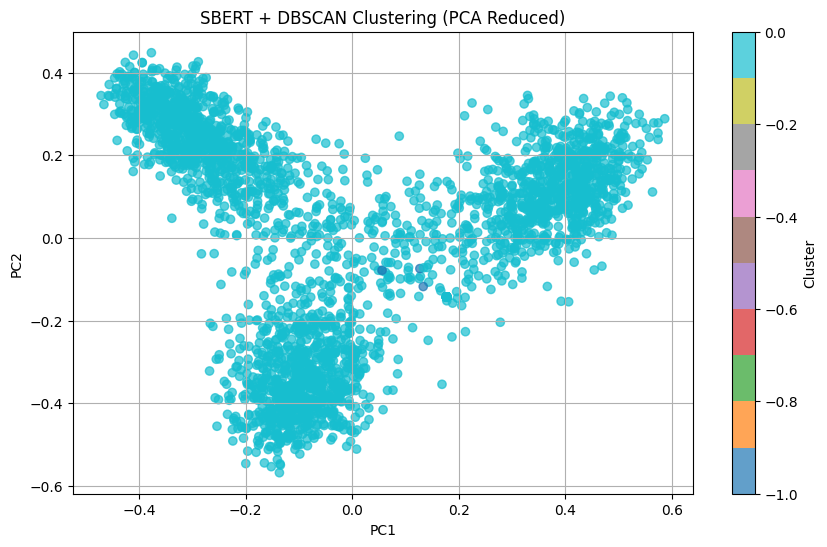

In [21]:
# Reduce SBERT vectors to 2D
pca = PCA(n_components=2, random_state=42)
X_sbert_pca = pca.fit_transform(X_sbert)

# Plot DBSCAN results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_sbert_pca[:, 0], X_sbert_pca[:, 1], c=sbert_dbscan_labels, cmap='tab10', alpha=0.7)
plt.title("SBERT + DBSCAN Clustering (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

**BERT Embedding**

In [22]:
# Load pretrained BERT
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model.eval()  # inference mode

# Get CLS embeddings for all texts
bert_embeddings = []

with torch.no_grad():
    for text in tqdm(processed_texts, desc="BERT embeddings"):
        inputs = bert_tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token
        bert_embeddings.append(cls_embedding)

# Convert to numpy array
import numpy as np
X_bert = np.array(bert_embeddings)

print("BERT Embedding Shape:", X_bert.shape)

BERT embeddings: 100%|██████████| 2981/2981 [07:41<00:00,  6.46it/s]

BERT Embedding Shape: (2981, 768)


BERT + KMeans Clustering

In [23]:
# KMeans clustering
kmeans_bert = KMeans(n_clusters=3, random_state=42)
bert_kmeans_labels = kmeans_bert.fit_predict(X_bert)

# Ground truth labels
targets = newsgroups.target

# Evaluation
ari = adjusted_rand_score(targets, bert_kmeans_labels)
nmi = normalized_mutual_info_score(targets, bert_kmeans_labels)
fmi = fowlkes_mallows_score(targets, bert_kmeans_labels)

print(f"BERT + KMeans - ARI: {ari:.4f}, NMI: {nmi:.4f}, FMI: {fmi:.4f}")

BERT + KMeans - ARI: 0.3032, NMI: 0.3504, FMI: 0.5522


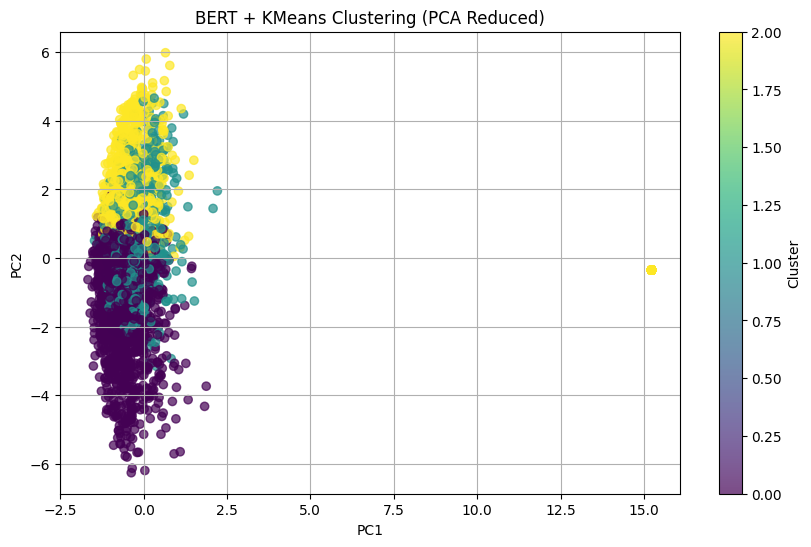

In [24]:
# Reduce BERT vectors to 2D
pca = PCA(n_components=2, random_state=42)
X_bert_pca = pca.fit_transform(X_bert)

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_bert_pca[:, 0], X_bert_pca[:, 1], c=bert_kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("BERT + KMeans Clustering (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

BERT + DBSCAN

In [25]:
# Run DBSCAN
dbscan_bert = DBSCAN(eps=3.5, min_samples=5, metric='cosine')  # You can tune these if needed
bert_dbscan_labels = dbscan_bert.fit_predict(X_bert)

# Evaluate only on non-noise points (DBSCAN assigns -1 to noise)
mask = bert_dbscan_labels != -1

if len(set(bert_dbscan_labels)) > 1:
    ari = adjusted_rand_score(targets[mask], bert_dbscan_labels[mask])
    nmi = normalized_mutual_info_score(targets[mask], bert_dbscan_labels[mask])
    fmi = fowlkes_mallows_score(targets[mask], bert_dbscan_labels[mask])
else:
    ari, nmi, fmi = 0.0, 0.0, 0.0

print(f"BERT + DBSCAN - ARI: {ari:.4f}, NMI: {nmi:.4f}, FMI: {fmi:.4f}")

BERT + DBSCAN - ARI: 0.0000, NMI: 0.0000, FMI: 0.0000


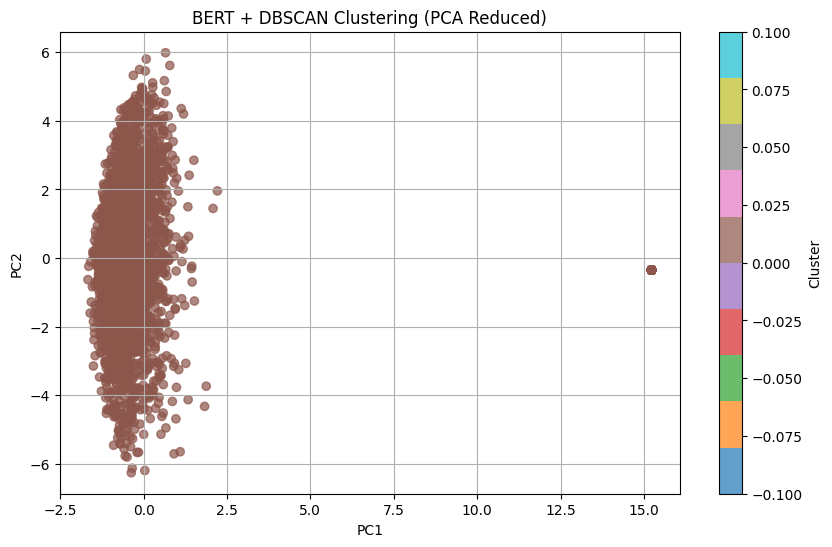

In [26]:
# Reduce dimensions to 2D
pca = PCA(n_components=2, random_state=42)
X_bert_pca = pca.fit_transform(X_bert)

# Plot only non-noise points
mask = bert_dbscan_labels != -1
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_bert_pca[mask, 0],
    X_bert_pca[mask, 1],
    c=bert_dbscan_labels[mask],
    cmap='tab10',
    alpha=0.7
)

plt.title("BERT + DBSCAN Clustering (PCA Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

**9. Saving the Best Model**

SBERT + KMeans model is serialized for future inference.

**✅ Final Choice:** SBERT + KMeans gave the best clustering performance (ARI: 0.8358, NMI: 0.7934, FMI: 0.8907) and is saved for future use.

In [27]:
import joblib

# Save SBERT model (it auto-downloads from HuggingFace anyway)
# So just saving KMeans and optionally embeddings if needed

# Save KMeans
joblib.dump(kmeans_sbert, 'sbert_kmeans_model.pkl')

# Optionally save sentence embeddings (for future visualization / indexing)
np.save('sbert_embeddings.npy', X_sbert)

print("✅ KMeans model and embeddings saved.")

✅ KMeans model and embeddings saved.
